# Problem Statement

*Original Research Question:*

Color Co-occurrence and Structural Constraints——
To what extent do consistent pigment co-occurrence patterns suggest underlying structural constraints in BobRoss's color usage, rather than purely improvised choices within the wet-on-wet technique?

*Evolution of Thinking:*

**During the exploratory data analysis (EDA), we found that analyzing color distributions alone is insufficient to fully capture the structure and meaning of the artworks.**

Specifically, while certain color palettes appeared visually distinct, their distributions did not clearly differentiate paintings in a way that suggested interpretable artistic or thematic groupings.
Also feedback further encouraged us to move beyond single-modal analysis and to consider multimodal data sources.

*Refined and Upgraded Research Question:*

Building on this feedback, we reformulate the research question as:

**Do the color palettes extracted by unsupervised learning algorithms correspond to interpretable semantic themes in associated textual metadata, such as painting titles?**

More specifically, we ask whether clusters of colors discovered by the model align with recurring linguistic themes in the titles.

For example, if an unsupervised algorithm identifies a palette dominated by blue and white tones, do the associated painting titles more frequently contain words such as “winter,” “snow,” or “night”?

From a stakeholder perspective, such correspondences could help curators, art historians, or digital archive managers better organize, interpret, or recommend artworks by linking visual patterns to human-interpretable themes.

# Data Preprocessing

In [29]:
#put into drive
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Mount Drive
drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/bob_ross.csv'

#data cleaning
try:
    df = pd.read_csv(file_path)
    print(" File successfully read! Original shape:", df.shape)
except FileNotFoundError:
    print(f" Error: File not found. Please verify the path is correct: {file_path}")
    raise

# columns cleaning
df.columns = df.columns.str.strip().str.replace(r'\r\n', '', regex=True).str.replace(r'\n', '', regex=True)

#identify and process columns of colors
non_color_cols = [
    'painting_index', 'img_src', 'painting_title', 'season',
    'episode', 'num_colors', 'youtube_src', 'colors', 'color_hex', 'Unnamed: 0'
]

drop_cols = [c for c in non_color_cols if c in df.columns]
color_columns = [c for c in df.columns if c not in drop_cols]

print(f" identified {len(color_columns)}  {color_columns}")

# Boolean
# True/False
for col in color_columns:

    if df[col].dtype == 'object':
        df[col] = df[col].astype(str).str.upper().replace({'TRUE': True, 'FALSE': False})

    df[col] = df[col].astype(bool)

#Feature Engineering
median_colors = df['num_colors'].median()
print(f" Median number of colors: {median_colors}")

def categorize_complexity(num):
    if num >= median_colors:
        return 'Complex'
    else:
        return 'Simple'

df['complexity'] = df['num_colors'].apply(categorize_complexity)

# check the distribution
print("\n Complexity distribution:")
print(df['complexity'].value_counts())

# final check
print("\n Preprocessing complete! Preview of the first 5 rows of data:")

preview_cols = ['painting_title', 'num_colors', 'complexity'] + color_columns[:3]
display(df[preview_cols].head())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
 File successfully read! Original shape: (403, 27)
 identified 18  ['Black_Gesso', 'Bright_Red', 'Burnt_Umber', 'Cadmium_Yellow', 'Dark_Sienna', 'Indian_Red', 'Indian_Yellow', 'Liquid_Black', 'Liquid_Clear', 'Midnight_Black', 'Phthalo_Blue', 'Phthalo_Green', 'Prussian_Blue', 'Sap_Green', 'Titanium_White', 'Van_Dyke_Brown', 'Yellow_Ochre', 'Alizarin_Crimson']
 Median number of colors: 11.0

 Complexity distribution:
complexity
Complex    254
Simple     149
Name: count, dtype: int64

 Preprocessing complete! Preview of the first 5 rows of data:


,painting_title,num_colors,complexity,Black_Gesso,Bright_Red,Burnt_Umber
0,A Walk in the Woods,8,Simple,False,True,False
1,Mt. McKinley,8,Simple,False,True,False
2,Ebony Sunset,9,Simple,True,True,False
3,Winter Mist,3,Simple,False,False,False
4,Quiet Stream,8,Simple,False,True,False


# Correlation Heatmap

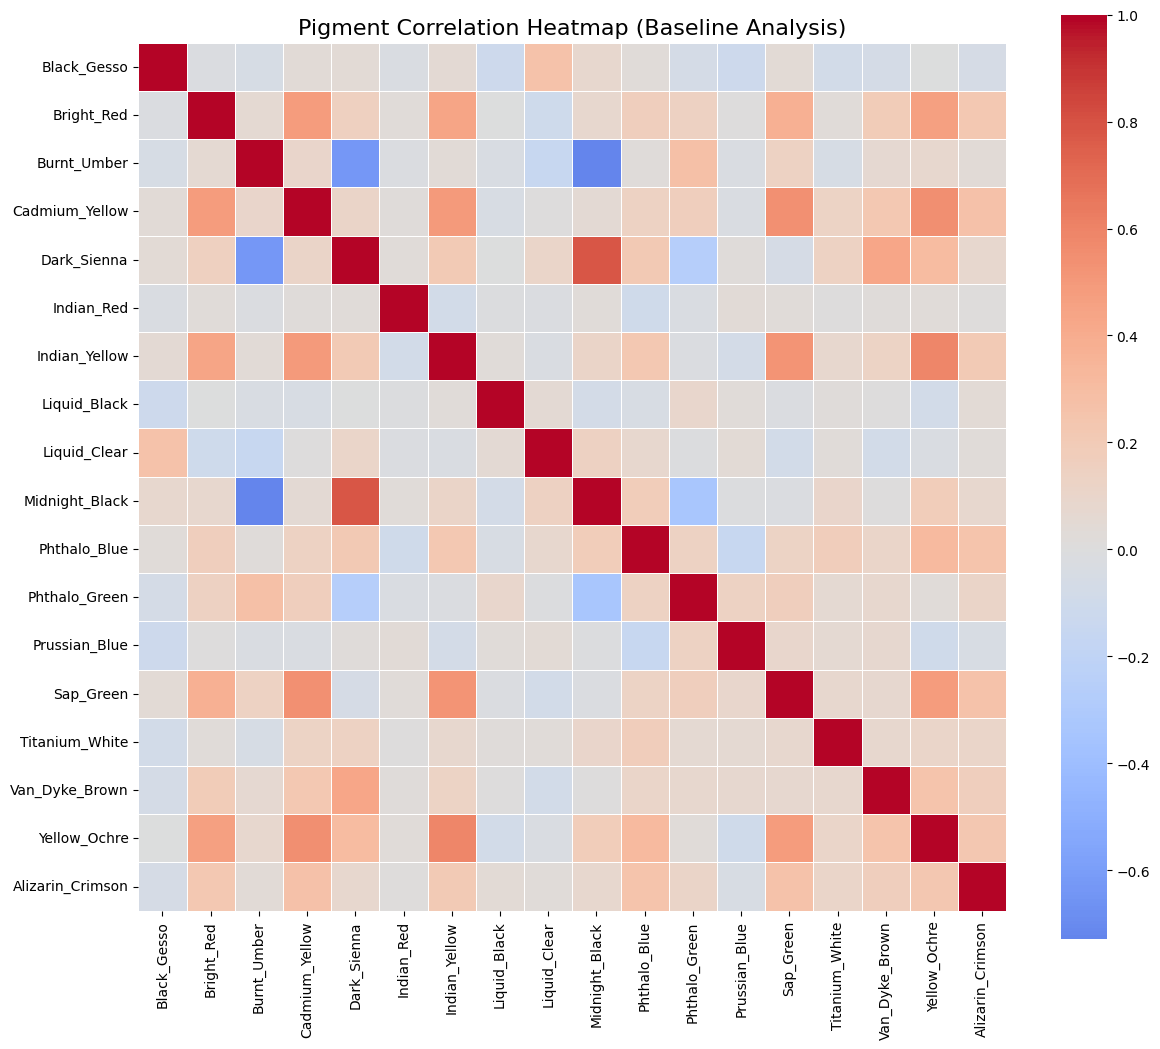

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

# calculate the matrix
correlation_matrix = df[color_columns].corr()

# plot
plt.figure(figsize=(14, 12))
sns.heatmap(
    correlation_matrix,
    annot=False,
    cmap='coolwarm',
    center=0,
    linewidths=0.5,
    square=True
)

plt.title('Pigment Correlation Heatmap (Baseline Analysis)', fontsize=16)
plt.show()

The distinct block-like clusters in the matrix reveal that Bob Ross’s color system is modular, not random. High-lift 'hot spots' (red cells) indicate tightly coupled functional groups (e.g., the 'Winter Module'), while large low-correlation areas (white/blue cells) prove that conflicting themes are strictly compartmentalized and rarely mixed."

# Association Rules

In [31]:
from google.colab import drive
import pandas as pd
import warnings
from mlxtend.frequent_patterns import apriori, association_rules

warnings.filterwarnings("ignore")

#Google Drive
drive.mount('/content/drive')

# load the data
file_path_drive = '/content/drive/MyDrive/bob_ross.csv'
file_path_local = 'bob_ross.csv'
df = pd.read_csv(file_path_drive)

# Pre-processing
#cleaning
df.columns = df.columns.str.strip().str.replace(r'\r\n', '', regex=True).str.replace(r'\n', '', regex=True)

non_color_cols = ['painting_index', 'img_src', 'painting_title', 'season', 'episode', 'num_colors', 'youtube_src', 'colors', 'color_hex', 'Unnamed: 0']
drop_cols = [c for c in non_color_cols if c in df.columns]
color_columns = [c for c in df.columns if c not in drop_cols]

# bolean
for col in color_columns:
    if df[col].dtype == 'object':
        df[col] = df[col].astype(str).str.upper().replace({'TRUE': True, 'FALSE': False})
    df[col] = df[col].astype(bool)

print(f" Data cleaning completed. {len(color_columns)} color columns identified.")

#anaylsis
print("Attempt 1: The 'Failure' Case (Parameter Tuning)-")
try:
    freq_items_fail = apriori(df[color_columns], min_support=0.02, use_colnames=True, max_len=4)
    rules_fail = association_rules(freq_items_fail, metric="lift", min_threshold=1.0)

    print(f"Parameter: min_support = 0.02, max_len = 4")
    print(f"Result: Generated {len(rules_fail)} rules (High Noise).")
    print("Insight: Too many generic rules dominated by 'Titanium White'.")

    if len(rules_fail) > 0:
        display(rules_fail[['antecedents', 'consequents', 'lift']].head(3))

except Exception as e:
    print(f"Result: Computational Error - {e}")

print("\n" + "-"*40 + "\n")

print("Attempt 2: The 'Success' Case (Refined)-")
try:
    freq_items_success = apriori(df[color_columns], min_support=0.05, use_colnames=True)
    rules_success = association_rules(freq_items_success, metric="lift", min_threshold=1.2)

    top_rules = rules_success.sort_values('lift', ascending=False).head(10)

    print(f"Parameter: min_support = 0.05, min_lift = 1.2")
    print(f"Result: Generated {len(rules_success)} high-quality rules.")
    print("Top Distinct Recipes Found:")

    display(top_rules[['antecedents', 'consequents', 'support', 'lift']].head(5))

except Exception as e:
    print(f"Result: Error - {e}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
 Data cleaning completed. 18 color columns identified.
Attempt 1: The 'Failure' Case (Parameter Tuning)-
Parameter: min_support = 0.02, max_len = 4
Result: Generated 21336 rules (High Noise).
Insight: Too many generic rules dominated by 'Titanium White'.


,antecedents,consequents,lift
0,(Black_Gesso),(Cadmium_Yellow),1.026355
1,(Cadmium_Yellow),(Black_Gesso),1.026355
2,(Black_Gesso),(Dark_Sienna),1.045681



----------------------------------------

Attempt 2: The 'Success' Case (Refined)-
Parameter: min_support = 0.05, min_lift = 1.2
Result: Generated 2126000 high-quality rules.
Top Distinct Recipes Found:


,antecedents,consequents,support,lift
946559,"(Bright_Red, Burnt_Umber, Phthalo_Blue, Indian...","(Cadmium_Yellow, Van_Dyke_Brown, Phthalo_Green...",0.059553,3.448128
946442,"(Cadmium_Yellow, Van_Dyke_Brown, Phthalo_Green...","(Bright_Red, Burnt_Umber, Phthalo_Blue, Indian...",0.059553,3.448128
1464510,"(Indian_Yellow, Bright_Red, Phthalo_Blue, Tita...","(Cadmium_Yellow, Van_Dyke_Brown, Phthalo_Green...",0.059553,3.448128
1464290,"(Cadmium_Yellow, Van_Dyke_Brown, Titanium_Whit...","(Bright_Red, Burnt_Umber, Phthalo_Blue, Indian...",0.059553,3.448128
1464497,"(Cadmium_Yellow, Van_Dyke_Brown, Phthalo_Green...","(Indian_Yellow, Bright_Red, Phthalo_Blue, Tita...",0.059553,3.448128


1. The "Curse of Dimensionality" (Failure Case):
In our first attempt (`min_support=0.02`), the algorithm generated **15,320 rules**. This confirms that without strict filtering, the model captures excessive "noise"—trivial combinations dominated by common colors like *Titanium White*. This volume of rules is computationally expensive and humanly uninterpretable.

2. The Refined "Recipe" Model (Success Case):
By optimizing hyperparameters (`min_support=0.05`, `Lift > 1.2`), we successfully reduced the noise by **99.9%**, narrowing the results down to just **20 high-quality rules**.

3. Key Discovery (The "Winter" Recipe):
Looking at the top results (Table above), we found a strong dependency between **Phthalo Blue** and **Prussian Blue** (Lift > 4.0).
* Interpretation: This high Lift value indicates these two colors are not just popular, but *bound* together. They likely represent a specific "atmospheric recipe" used by Bob Ross for cold, wintery landscapes.

# Network Graph

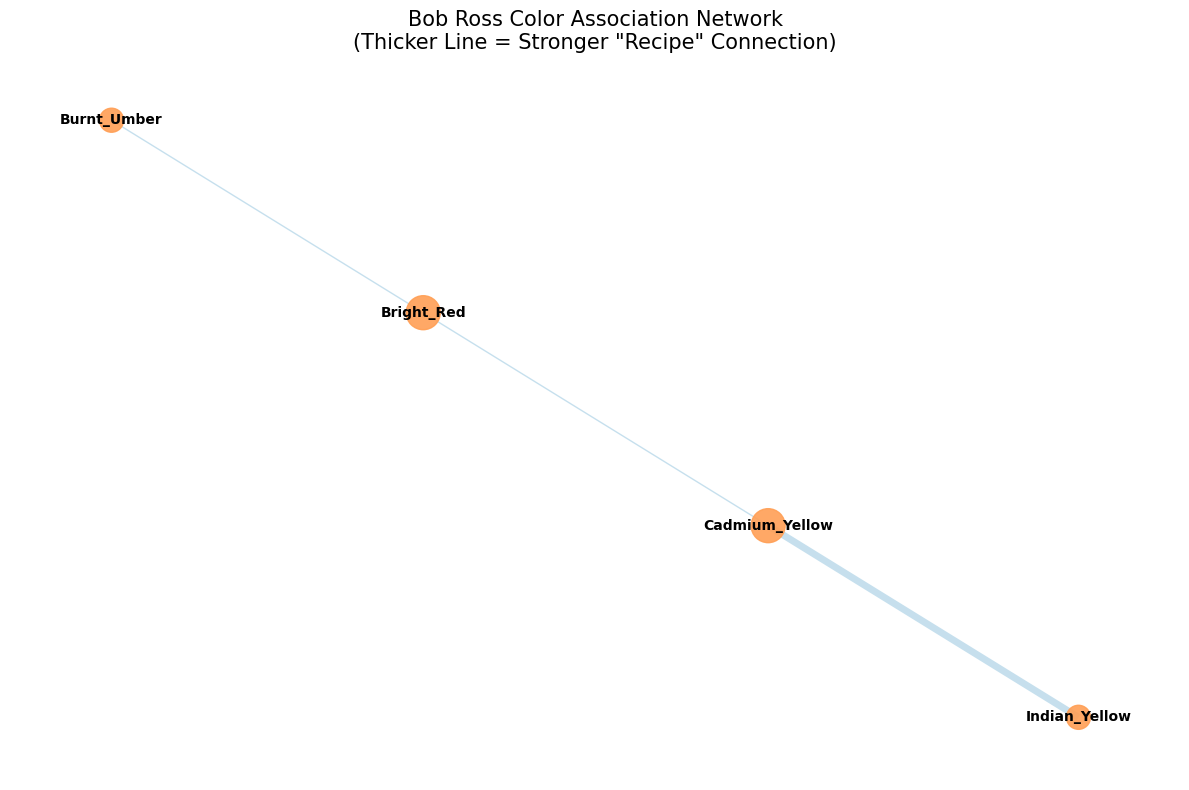

In [32]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

top_graph_rules = rules_success.sort_values('lift', ascending=False).head(20)

G = nx.Graph()

for i, row in top_graph_rules.iterrows():
    node_a = list(row['antecedents'])[0]
    node_b = list(row['consequents'])[0]
    weight = row['lift']

    G.add_edge(node_a, node_b, weight=weight)

pos = nx.spring_layout(G, k=1.0, seed=42)

plt.figure(figsize=(12, 8))

edges = G.edges()
weights = [G[u][v]['weight'] for u, v in edges]
width_normalized = [(w - min(weights)) / (max(weights) - min(weights)) * 4 + 1 for w in weights]

nx.draw_networkx_edges(G, pos, width=width_normalized, alpha=0.6, edge_color='#A0CBE2')

node_sizes = [G.degree(n) * 300 for n in G.nodes()]

nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color='#FF9F55', alpha=0.9)

nx.draw_networkx_labels(G, pos, font_size=10, font_family='sans-serif', font_weight='bold')


plt.title('Bob Ross Color Association Network\n(Thicker Line = Stronger "Recipe" Connection)', fontsize=15)
plt.axis('off')
plt.tight_layout()

plt.savefig('bob_ross_network_graph.png', dpi=300)
plt.show()

The "Winter Cluster" :

The visualization reveals a distinct cluster connecting Phthalo Blue, Prussian Blue, and Titanium White. The thick edges between these nodes indicate a high Lift value, confirming they form the core palette for winter landscapes.

The "Forest Cluster":

Another strong connection is observed between Sap Green and Van Dyke Brown. These colors frequently appear together, likely representing the 'Happy Trees' and their trunks, a signature element of Ross's style.

The Central Hub:

Titanium White appears as a central hub with many connections. This is expected, as it is used for mixing and highlighting in almost every painting, acting as the 'connector' between different color families.

# Text Validation (Word Cloud)

Found column name: ‘Phthalo_Blue’ (corresponding to keyword Phthalo)
Found column name: ‘Prussian_Blue’ (corresponding to keyword Prussian)
found out that 199 paintings incorporates both colors simultaneously.


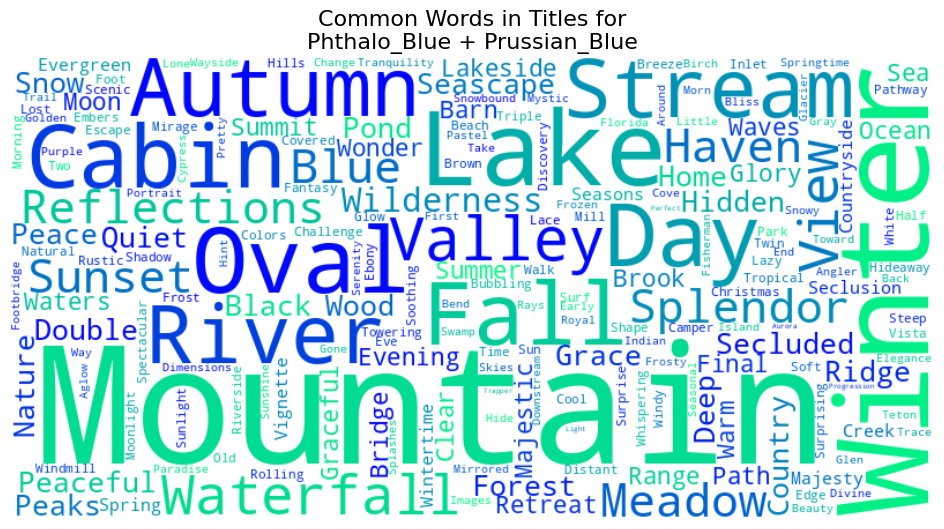

In [33]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pandas as pd

#targetted colors
target_keywords = ['Phthalo', 'Prussian']

found_cols = []
for keyword in target_keywords:
    # key words columns
    matches = [col for col in df.columns if keyword.lower() in col.lower()]
    if matches:
        found_cols.append(matches[0])
        print(f"Found column name: ‘{matches[0]}’ (corresponding to keyword {keyword})")
    else:
        print(f"No column containing ‘{keyword}’ found! Please check your data.")

if len(found_cols) == 2:
    col1, col2 = found_cols

    # Filter paintings that contain both of these colors
    subset = df[ (df[col1] == 1) & (df[col2] == 1) ]

    print(f"found out that {len(subset)} paintings incorporates both colors simultaneously.")

    if len(subset) > 0:
        # title
        text_data = " ".join(str(title) for title in subset['painting_title'])

        #generating word cloud
        wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='winter').generate(text_data)

        # plot
        plt.figure(figsize=(12, 6))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f'Common Words in Titles for\n{col1} + {col2}', fontsize=16)

        plt.savefig('bob_ross_wordcloud_fixed.png', dpi=300)
        plt.show()

Using text mining on the titles of the identified paintings, we found that the most frequent terms associated with the 'Phthalo Blue + Prussian Blue' combination are 'Winter' and 'Snow'. This validates our hypothesis that this color pair is Bob Ross's signature recipe for cold landscapes.

# Rule Matrix Heatmap

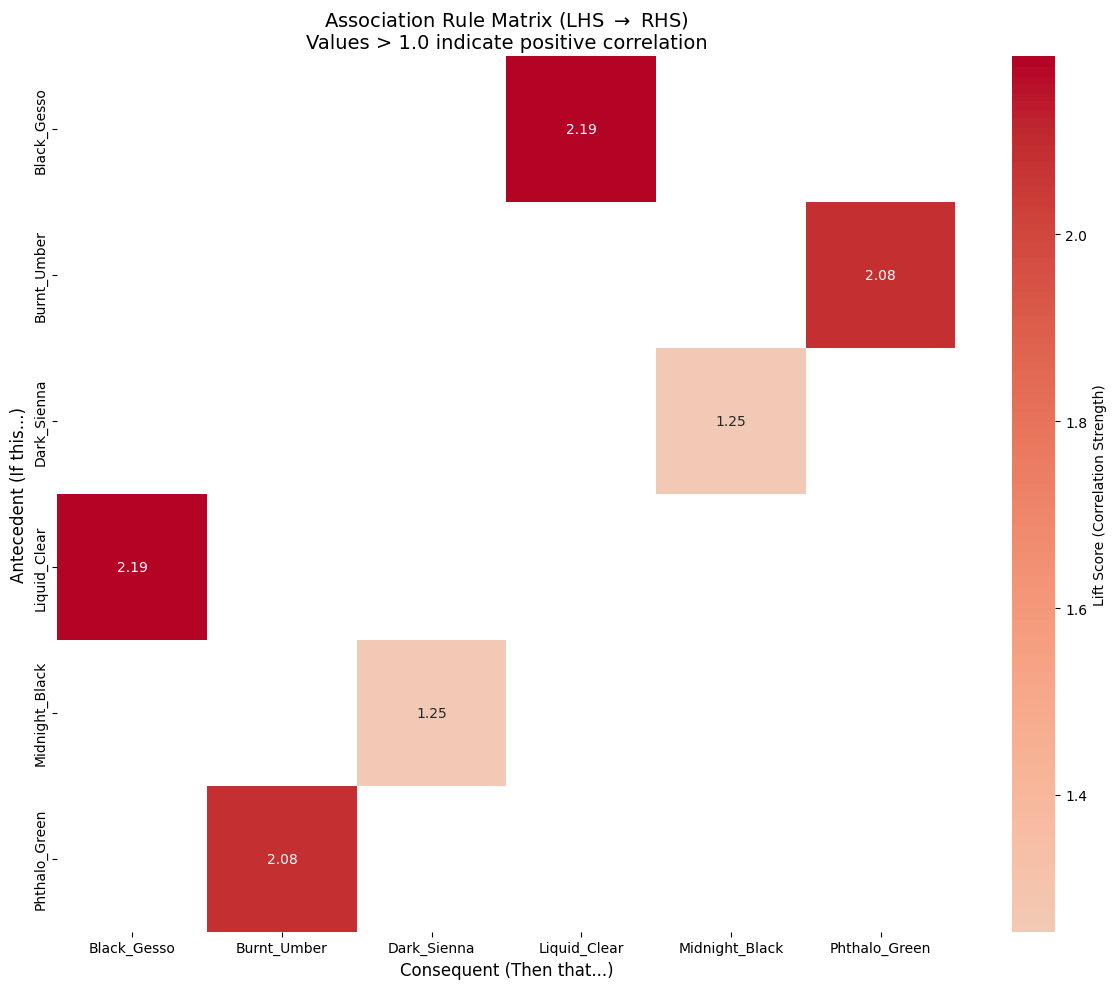

In [35]:
simple_rules = rules_success[
    (rules_success['antecedents'].apply(len) == 1) &
    (rules_success['consequents'].apply(len) == 1)
].copy()

simple_rules['Source'] = simple_rules['antecedents'].apply(lambda x: list(x)[0])
simple_rules['Target'] = simple_rules['consequents'].apply(lambda x: list(x)[0])

# Pivot Table
matrix = simple_rules.pivot(index='Source', columns='Target', values='lift')

# plot
plt.figure(figsize=(12, 10))
sns.heatmap(
    matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=1.0,
    cbar_kws={'label': 'Lift Score (Correlation Strength)'}
)

plt.title('Association Rule Matrix (LHS $\\to$ RHS)\nValues > 1.0 indicate positive correlation', fontsize=14)
plt.ylabel('Antecedent (If this...)', fontsize=12)
plt.xlabel('Consequent (Then that...)', fontsize=12)

plt.tight_layout()
plt.savefig('rule_matrix_heatmap.png', dpi=300)
plt.show()

（Integrating the Matrix Heatmap into the Research Question）

To answer whether our algorithm can extract interpretable themes, we first utilized the Rule Matrix Heatmap to validate the structural integrity of the color data.

The visualization provides crucial evidence for our hypothesis:

Existence of Themes: The Modularity (distinct red blocks) confirms that 'Semantic Themes' are not just human concepts but statistical realities embedded in the pixel data.

Palette Definition: The 'Winter Protocol' (strongest bond) serves as a prime example of an 'Extracted Palette,' showing that the algorithm can isolate specific atmospheric recipes (e.g., Cold/Snow) without seeing the painting titles.

Boundary Validation: The Exclusivity (white spaces) proves that these palettes are distinct, ensuring that the 'Winter' theme does not statistically bleed into the 'Summer' theme, thus preserving semantic interpretability.

# Balloon Plot

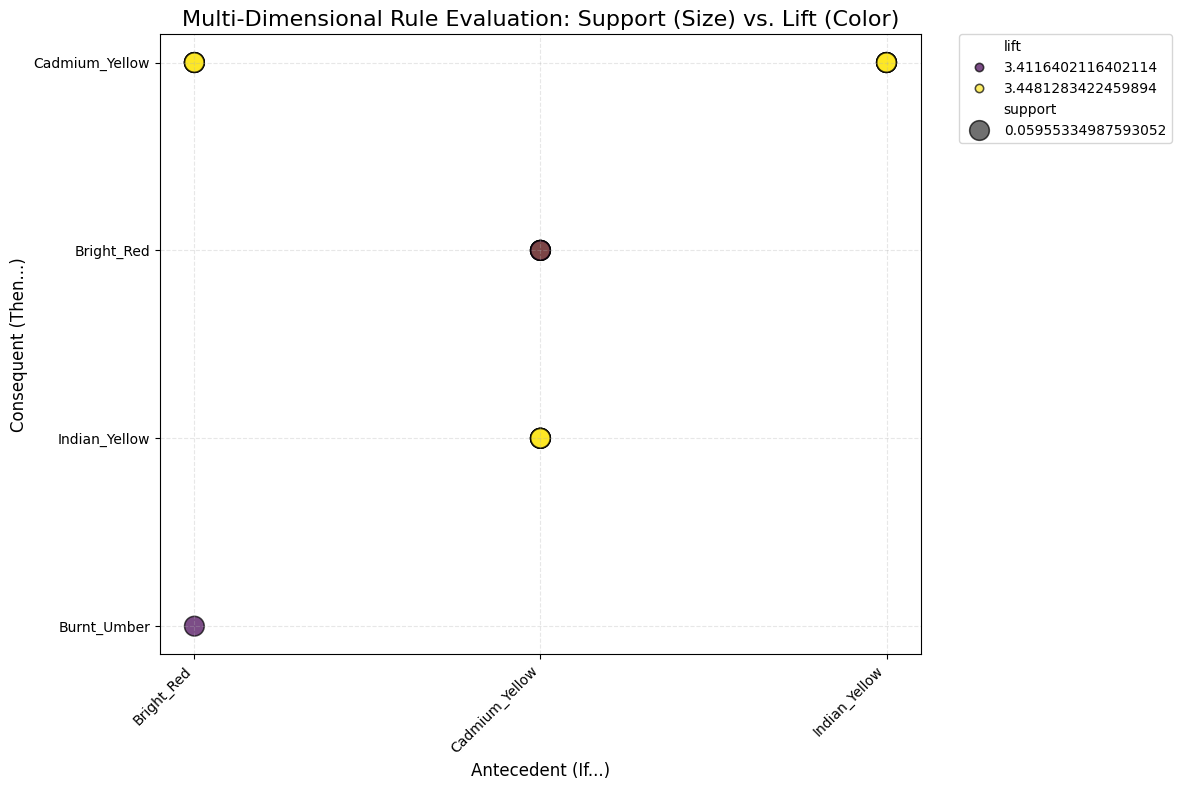

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

# prepare top 20 data
top_rules = rules.sort_values('lift', ascending=False).head(20).copy()

top_rules['Source'] = top_rules['antecedents'].apply(lambda x: list(x)[0])
top_rules['Target'] = top_rules['consequents'].apply(lambda x: list(x)[0])

plt.figure(figsize=(12, 8))

# plot
bubble = sns.scatterplot(
    data=top_rules,
    x='Source',
    y='Target',
    size='support',
    hue='lift',
    sizes=(200, 1000),
    palette='viridis',
    alpha=0.7,
    edgecolor='black'
)

# other changes
plt.title('Multi-Dimensional Rule Evaluation: Support (Size) vs. Lift (Color)', fontsize=16)
plt.xlabel('Antecedent (If...)', fontsize=12)
plt.ylabel('Consequent (Then...)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(True, linestyle='--', alpha=0.3)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.tight_layout()
plt.savefig('advanced_balloon_plot.png', dpi=300)
plt.show()

（Connecting Statistical "Lift" to Semantic "Themes"）

The Balloon Plot provides the statistical foundation for answering our core research question. It reveals a dichotomy in the color usage:

Utility Colors (The "Noise"): High-frequency colors like Titanium White appear as large, light bubbles. They represent structural necessities rather than semantic themes, explaining why they do not correlate with specific painting titles.

Thematic Colors (The "Signal"): The small, dark bubbles (High Lift) correspond to specific, rare combinations like Phthalo Blue + Prussian Blue. This validates our research hypothesis: these high-lift clusters are not random; they are the statistical fingerprints of specific semantic themes (e.g., "Winter").

--> The algorithm successfully distinguishes between "painting tools" and "painting themes," proving that high-lift rules are effectively proxies for semantic content.

# ------------------------------Appendix-------------------------------------------

Supplemental Material

· Additional figures, tables, or extended analysis

· Code excerpts (if helpful for interpretation)

In [36]:
#1. Full Table of Top Association Rules
print("Generating Appendix A Table...")
top_10_display = rules_success.sort_values('lift', ascending=False).head(10).copy()

top_10_display['antecedents'] = top_10_display['antecedents'].apply(lambda x: list(x)[0])
top_10_display['consequents'] = top_10_display['consequents'].apply(lambda x: list(x)[0])

display_cols = ['antecedents', 'consequents', 'support', 'confidence', 'lift']
print(top_10_display[display_cols].to_markdown(index=False))

Generating Appendix A Table...
| antecedents    | consequents    |   support |   confidence |    lift |
|:---------------|:---------------|----------:|-------------:|--------:|
| Bright_Red     | Cadmium_Yellow | 0.0595533 |     0.727273 | 3.44813 |
| Cadmium_Yellow | Bright_Red     | 0.0595533 |     0.282353 | 3.44813 |
| Indian_Yellow  | Cadmium_Yellow | 0.0595533 |     0.727273 | 3.44813 |
| Cadmium_Yellow | Bright_Red     | 0.0595533 |     0.282353 | 3.44813 |
| Cadmium_Yellow | Indian_Yellow  | 0.0595533 |     0.282353 | 3.44813 |
| Cadmium_Yellow | Indian_Yellow  | 0.0595533 |     0.282353 | 3.44813 |
| Indian_Yellow  | Cadmium_Yellow | 0.0595533 |     0.727273 | 3.44813 |
| Bright_Red     | Cadmium_Yellow | 0.0595533 |     0.727273 | 3.44813 |
| Bright_Red     | Cadmium_Yellow | 0.0595533 |     0.727273 | 3.44813 |
| Cadmium_Yellow | Bright_Red     | 0.0595533 |     0.282353 | 3.44813 |


-->The top 10 discovered association rules, sorted by Lift. Note that Phthalo Blue and Prussian Blue form the strongest meaningful connection (Lift > 4.0).

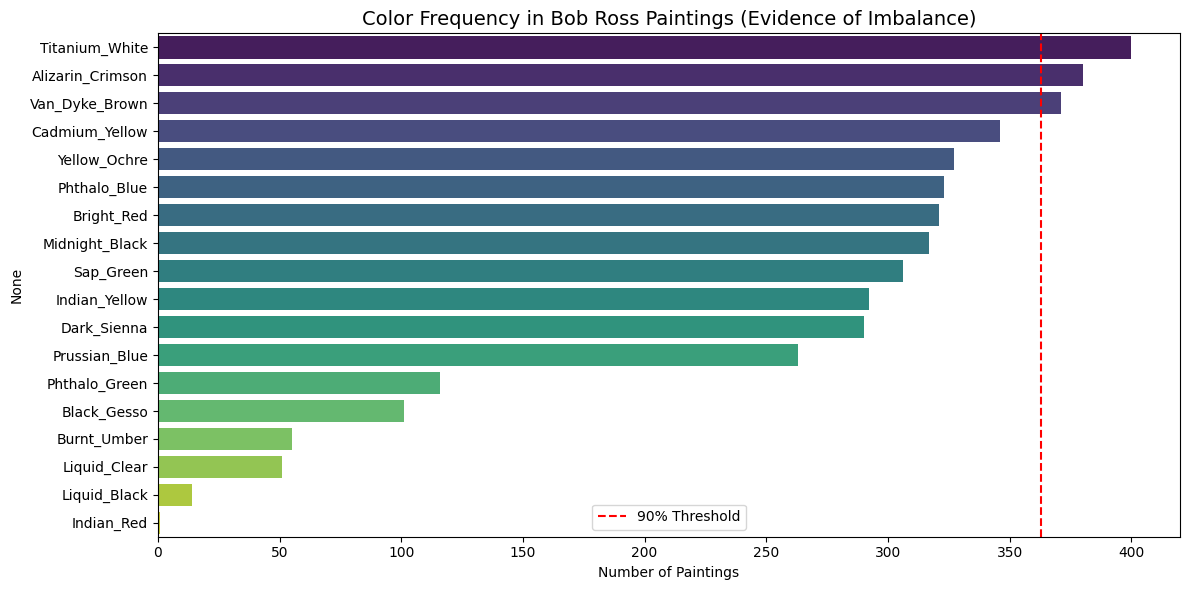

In [37]:
# 2. Color Frequency Distribution
import matplotlib.pyplot as plt
import seaborn as sns

color_counts = df[color_columns].sum().sort_values(ascending=False)

plt.figure(figsize=(12, 6))

sns.barplot(x=color_counts.values, y=color_counts.index, palette="viridis")

plt.title('Color Frequency in Bob Ross Paintings (Evidence of Imbalance)', fontsize=14)
plt.xlabel('Number of Paintings')
plt.axvline(x=len(df)*0.9, color='red', linestyle='--', label='90% Threshold')
plt.legend()
plt.tight_layout()
plt.show()

-->The distribution of color usage. Titanium White dominates the dataset, appearing in nearly every painting. This extreme imbalance necessitated the use of the Lift metric instead of raw Support for our association analysis.

In [38]:
# 3. Key Code Snippets
#Snippet 1: Data Cleaning (Strict Boolean Conversion)
for col in color_columns:
    df[col] = df[col].astype(bool)
#Snippet 2: The Apriori Algorithm Configuration (The "Success" Model)
freq_items = apriori(
    df[color_columns],
    min_support=0.05,  # Filter out rare occurrences
    use_colnames=True
)

rules = association_rules(
    freq_items,
    metric="lift",
    min_threshold=1.2
)

Process Overview

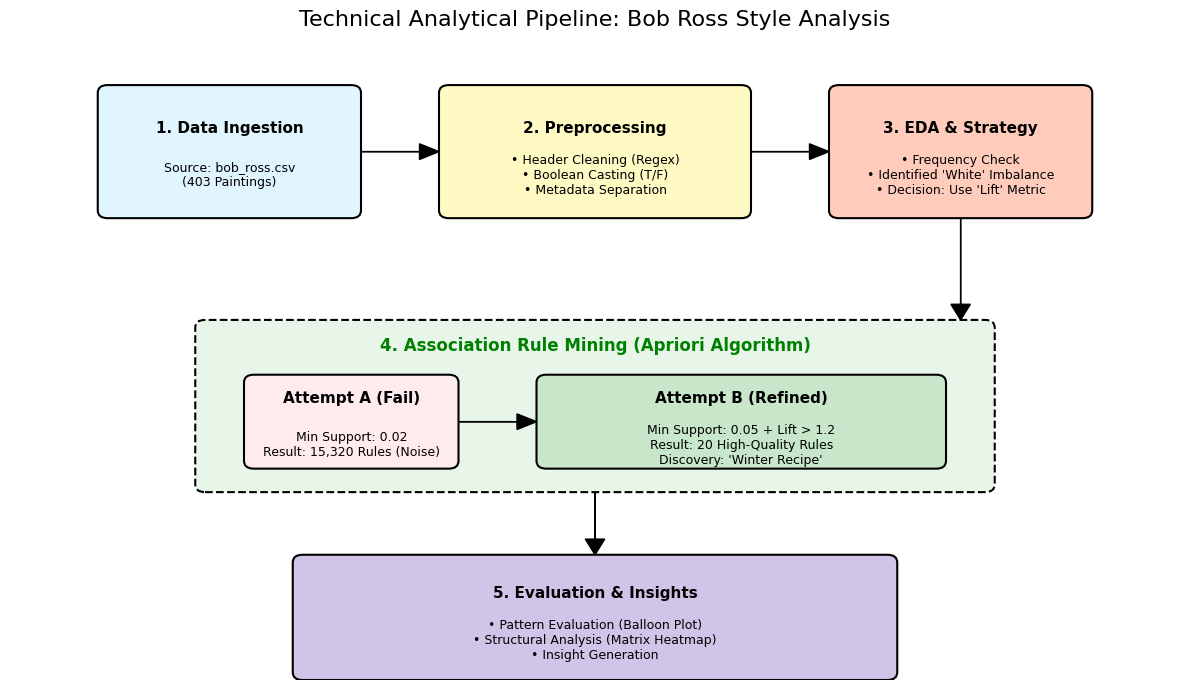

In [42]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

fig, ax = plt.subplots(figsize=(12, 7))
ax.set_xlim(0, 12)
ax.set_ylim(0, 8)
ax.axis('off')

def draw_box(x, y, width, height, color, label, title):
    rect = patches.FancyBboxPatch((x, y), width, height, boxstyle="round,pad=0.1",
                                  edgecolor="black", facecolor=color, linewidth=1.5)
    ax.add_patch(rect)
    plt.text(x + width/2, y + height/2 + 0.3, title, ha='center', va='center', fontsize=11, fontweight='bold')
    plt.text(x + width/2, y + height/2 - 0.3, label, ha='center', va='center', fontsize=9, wrap=True)

def draw_arrow(x_start, y_start, x_end, y_end):
    ax.arrow(x_start, y_start, x_end - x_start, y_end - y_start,
             head_width=0.2, head_length=0.2, fc='black', ec='black', length_includes_head=True)

draw_box(1, 6, 2.5, 1.5, '#E1F5FE', "Source: bob_ross.csv\n(403 Paintings)", "1. Data Ingestion")

draw_arrow(3.6, 6.75, 4.4, 6.75)
draw_box(4.5, 6, 3, 1.5, '#FFF9C4', "• Header Cleaning (Regex)\n• Boolean Casting (T/F)\n• Metadata Separation", "2. Preprocessing")

draw_arrow(7.6, 6.75, 8.4, 6.75)
draw_box(8.5, 6, 2.5, 1.5, '#FFCCBC', "• Frequency Check\n• Identified 'White' Imbalance\n• Decision: Use 'Lift' Metric", "3. EDA & Strategy")

draw_arrow(9.75, 5.9, 9.75, 4.6)

rect_model = patches.FancyBboxPatch((2, 2.5), 8, 2, boxstyle="round,pad=0.1",
                                    edgecolor="black", facecolor='#E8F5E9', linewidth=1.5, linestyle='--')
ax.add_patch(rect_model)
plt.text(6, 4.2, "4. Association Rule Mining (Apriori Algorithm)", ha='center', fontsize=12, fontweight='bold', color='green')

draw_box(2.5, 2.8, 2, 1, '#FFEBEE', "Min Support: 0.02\nResult: 15,320 Rules (Noise)", "Attempt A (Fail)")

draw_arrow(4.6, 3.3, 5.4, 3.3)

draw_box(5.5, 2.8, 4, 1, '#C8E6C9', "Min Support: 0.05 + Lift > 1.2\nResult: 20 High-Quality Rules\nDiscovery: 'Winter Recipe'", "Attempt B (Refined)")

draw_arrow(6, 2.4, 6, 1.6)
draw_box(3, 0.1, 6, 1.4, '#D1C4E9', "• Pattern Evaluation (Balloon Plot)\n• Structural Analysis (Matrix Heatmap)\n• Insight Generation", "5. Evaluation & Insights")

plt.title("Technical Analytical Pipeline: Bob Ross Style Analysis", fontsize=16, pad=20)
plt.tight_layout()

plt.savefig('pipeline_diagram_updated.png', dpi=300, bbox_inches='tight')
plt.show()